# Reconciling Experts

This tutorial demonstrates how time dependent expert opinions can be reconciled in a Bayesian framework.

# Some Preliminaries

We can view the a time dependent expert opinion $x_i$ as a random walk process developing over time step $i$ such that

$$
x_{i+1} = x_i + \epsilon_i
$$

We will use the `ARIMA` package to model this time series in Pyro, but any other Pyro model can be used.

We start with some imports.

In [1]:
import torch
import pyro

import pyro.distributions
from pyro.nn import PyroModuleList, PyroModule, PyroSample
from ARIMA import BayesianARIMA

from matplotlib import pyplot as plt

Now let's define the model as a class.

In [2]:
class Model(PyroModule):
    def __init__(self, num_time_steps, num_series):
        super().__init__()
        self.time_series = PyroModuleList([
            BayesianARIMA(0, 1, 0, 0, 0, 0, 1,
                          o_tail_type='zero', # Use zero as the starting point
                          predict_idx=[*range(num_time_steps - 1)],
                          obs_idx=[num_time_steps - 1]) # We would like to observe the last value
                for count in range(num_series)])
        for time_series in self.time_series: # Set prior for the variance of the innovations
            time_series.innovations_dist.sigma = PyroSample(pyro.distributions.LogNormal(loc=0, scale=1))

    def forward(self):
        return torch.cat([time_series.predict()[..., None] for time_series in self.time_series], dim=-1)

The `Model` class supports multiple time series.

Below we create the model with two time series.

In [3]:
num_time_steps = 50
num_series = 2

model = Model(num_time_steps=num_time_steps, num_series=num_series)

As the model is Bayesian it has priors for all of its parameters and we can sample from it right away, even without any observations.

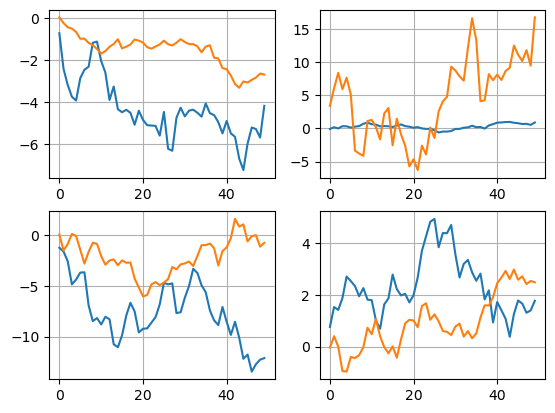

In [4]:
seed = 20240711
pyro.set_rng_seed(seed)
pyro.clear_param_store()

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(model().detach().numpy())
    plt.grid()

The two time series are independent and have different step variance. The model can be described by the directed graph shown below, where each node represents a random variable and the edges represent the dependencies between the random variables

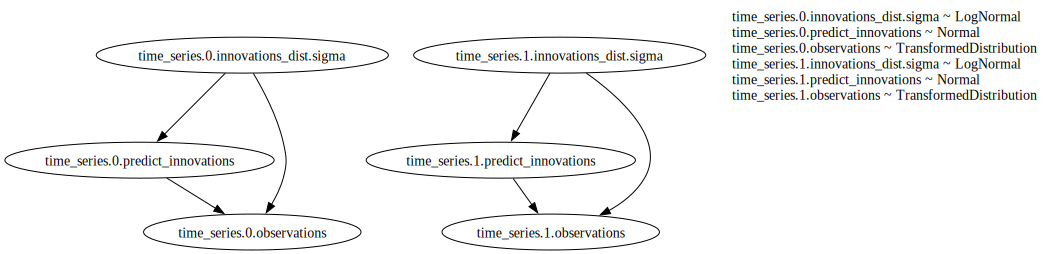

In [5]:
from ARIMA.pyro_utils import render_model

render_model(model)

The directed graph describes the model's probability function which assigns a probability to each outcome of the model.

$$
P_M \left( x_i^{(j)}, \epsilon_i^{(j)} \right)
$$

# Prior Knowledge and Model Conditioning

Model conditioning allows us to incorporate prior knowledge into the model, altering its predictions to reflect the effect of the prior knowledge.

We mark the conditionining of the model with by

$$
P_M \left( x_i^{(j)}, \epsilon_i^{(j)} | \text{condition} \right) =
\frac{ P_M \left( x_i^{(j)}, \epsilon_i^{(j)}, \text{condition} \right) }{ P_M \left( \text{condition} \right) }
$$

which is usually difficult to calculate and sample from. Note that index $i$ marks the time step and index $j$ marks the time series (expert).

A very simple form of model conditioning can be setting the last observation of both time series to zero, as described in the conditined model defined below.

In [6]:
zero_ultimate_model = pyro.poutine.condition(model, data={f"time_series.{n}.observations":
                                                          torch.zeros_like(model.time_series[n]())
                                                          for n in range(len(model.time_series))})


Now comes the tricky part, we need a way in to sample from the conditioned model. The method we choose is called Stochastic Variational Inference (SVI) but othe methods like Markov Chain Monte Carlo (MCMC) will also do. SVI creates a guide which approximates the distribution of samples from the conditioned model. 

In [7]:
def fit(model, *args, **kwargs):
    guide = pyro.infer.autoguide.guides.AutoMultivariateNormal(model)
    optimizer = pyro.optim.Adam(dict(lr=0.01))
    loss = pyro.infer.JitTrace_ELBO(num_particles=20, vectorize_particles=True, ignore_jit_warnings=True)
    svi = pyro.infer.SVI(model, guide, optimizer, loss)
    for count in range(1001):
        loss = svi.step(*args, **kwargs)
        if count % 100 == 0:
            print(f"iteration {count} loss = {loss}")
    return guide

pyro.set_rng_seed(seed)
pyro.clear_param_store()

guide = fit(zero_ultimate_model)

iteration 0 loss = 200.58303833007812
iteration 100 loss = 36.983760833740234
iteration 200 loss = 33.36922073364258
iteration 300 loss = 17.469837188720703
iteration 400 loss = 19.778776168823242
iteration 500 loss = 19.781892776489258
iteration 600 loss = 14.55040454864502
iteration 700 loss = 23.988422393798828
iteration 800 loss = 17.312591552734375
iteration 900 loss = 13.009325981140137
iteration 1000 loss = 22.540828704833984


We now sample from the conditioned model and guide, in order to show how the conditioned model behaves.

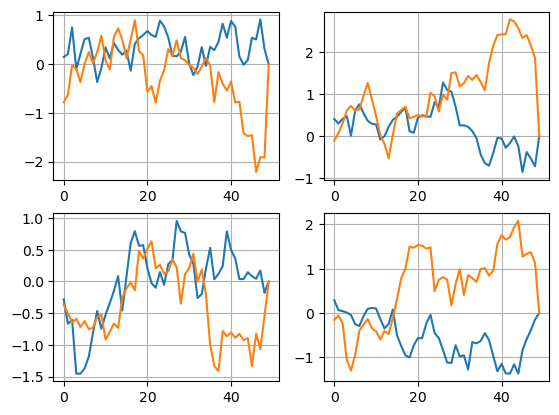

In [8]:
sampler = pyro.infer.Predictive(zero_ultimate_model, guide=guide,
                                num_samples=1000, parallel=True, return_sites=('_RETURN',))
samples = sampler()['_RETURN']

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(samples[i].detach().numpy())
    plt.grid()

A more interesting conditioned model is one where both time series must converge to the same value, but not necessarily zero. This is how a panel of experts would behave, where ongoing predictions of an ultimate value, by all experts, must eventually converge to the same value.

The model that describes such a condition is described below.

In [9]:
class SameUltimateModel(Model):
    def forward(self):
        ultimate = self.time_series[0].observations
        with pyro.poutine.condition(data={f"time_series.{n}.observations":ultimate
                                          for n in range(1, len(self.time_series))}):
            return super().forward()

Sampling from this model requires creating a new guide.

In [10]:
same_ultimate_model = SameUltimateModel(num_time_steps, num_series)

pyro.set_rng_seed(seed)
pyro.clear_param_store()

guide = fit(same_ultimate_model)

iteration 0 loss = 193.56320190429688
iteration 100 loss = 39.2830696105957
iteration 200 loss = 24.114076614379883
iteration 300 loss = 21.66083335876465
iteration 400 loss = 18.020967483520508
iteration 500 loss = 16.448196411132812
iteration 600 loss = 24.82901382446289
iteration 700 loss = 16.96342658996582
iteration 800 loss = 17.92446517944336
iteration 900 loss = 20.773021697998047
iteration 1000 loss = 17.82803726196289


Equipeed with the new guide we can now sample from the same ultimate value model.

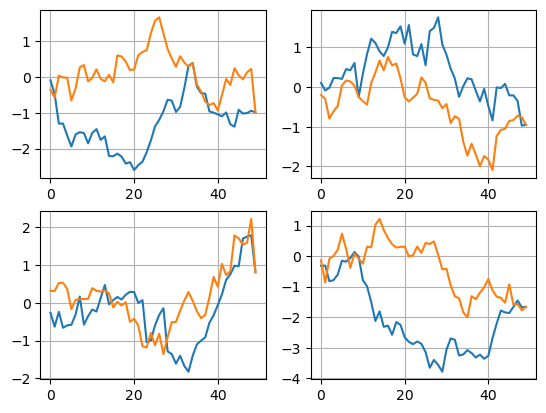

In [11]:
sampler = pyro.infer.Predictive(same_ultimate_model, guide=guide,
                                num_samples=1000, parallel=True, return_sites=('_RETURN',))
samples = sampler()['_RETURN']

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(samples[i].detach().numpy())
    plt.grid()

The model exhibits the correct behavior with ultimate values of both time series converging to the same value.

# Adding Observations

Lastly, we would like to be able to take into account actual observations when working with the `SameUltimateModel` model. This  completes the Bayesian framework which incorporates our:
- Model.
- Prior knowledge.
- Observations.

In order to do that we need to modify the `SameUltimateModel` so that we can observe not just the last sample.

In [12]:
class SameUltimateModel(Model):
    def forward(self, observations):
        with pyro.poutine.condition(data={"time_series.0.observations":observations[..., 0]}):
            # Get observations that include the last sample from the first time series
            ultimate = self.time_series[0].predict()[self.time_series[0].innovations_dist.slice(
                                                                         self.time_series[0].obs_idx + [-1])]
            # Condition the last sample of all remaining time series to be the same as that of the first time series
            data = dict()
            for n, time_series in enumerate(self.time_series):
                ultimate[..., :-1] = observations[..., n]
                data[f"time_series.{n}.observations"] = ultimate.clone()
            with pyro.poutine.condition(data=data):
                return super().forward()

Create the model and modify the observed samples to be the first half of all the samples.

In [13]:
same_ultimate_model = SameUltimateModel(num_time_steps, num_series)

for n, time_series in enumerate(same_ultimate_model.time_series):
    obs_idx = set(range(int(num_time_steps / 2)))
    if n > 0:
        obs_idx = obs_idx.union(set([num_time_steps - 1]))
    predict_idx = set(range(num_time_steps)) - obs_idx
    time_series.set_indices(obs_idx, predict_idx)

We now fit the model to the first half of the samples generated in the first sub-plot of the previous graph, by creating a new guide that enables sampling from the model combining both prior knowledge and actual observations.

In [14]:
pyro.set_rng_seed(seed)
pyro.clear_param_store()

observations = samples[0][..., range(int(num_time_steps / 2)), :]
guide = fit(same_ultimate_model, observations)

iteration 0 loss = 130.611572265625
iteration 100 loss = 28.751880645751953
iteration 200 loss = 22.952451705932617
iteration 300 loss = 22.937747955322266
iteration 400 loss = 22.942455291748047
iteration 500 loss = 22.56819725036621
iteration 600 loss = 22.086570739746094
iteration 700 loss = 22.61164665222168
iteration 800 loss = 22.45270538330078
iteration 900 loss = 21.786209106445312
iteration 1000 loss = 22.38797378540039


We now sample from the newly created guide.

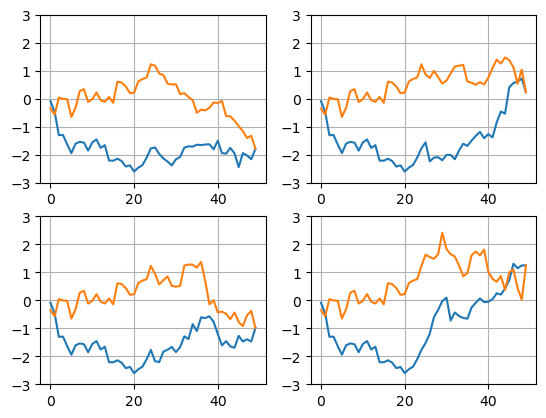

In [15]:
new_sampler = pyro.infer.Predictive(same_ultimate_model, guide=guide,
                                    num_samples=1000, parallel=True, return_sites=('_RETURN',))
new_samples = new_sampler(observations)['_RETURN']

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(new_samples[i].detach().numpy())
    plt.ylim([-3, 3])
    plt.grid()

We can see that all samples are comprised of the same first half of observed samples, while still maintaining the same end value for both time series (our prior knowledge).

Overlayling many samples over each other we see that both time series (experts) tend towards each other in order to ensure agreement is achieved at the last samples.

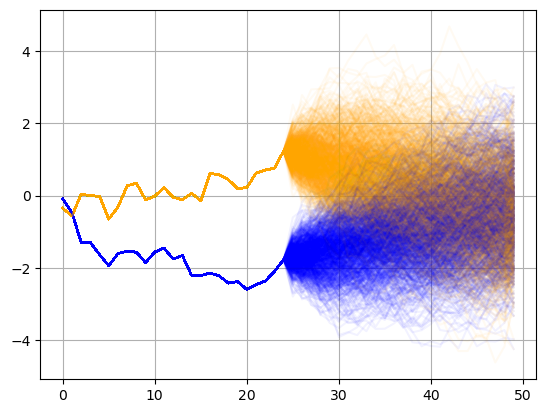

In [16]:
plt.figure()
for i in range(1000):
    plt.plot(new_samples[i, ..., 0].detach().numpy(), alpha=0.05, color='blue')
    plt.plot(new_samples[i, ..., 1].detach().numpy(), alpha=0.05, color='orange')
plt.grid()